# Vanilla RNN with Different Word Embeddings for Sentiment Analysis

## Overview
This notebook experiments with Vanilla RNN models using various word embedding techniques for Twitter sentiment classification.

## Word Embeddings Tested
1. **Trainable Embedding** - Learned from scratch during training
2. **Word2Vec** - Pre-trained or trained on our corpus
3. **GloVe** - Pre-trained embeddings (Twitter-specific)
4. **FastText** - Subword embeddings (handles OOV words better)

## Model Architecture
- Embedding Layer → Vanilla RNN → Dense → Output (3 classes)

## Evaluation
- Accuracy, Precision, Recall, F1-Score
- Training curves
- Comparison across embedding types

## 1. Import Libraries

In [56]:
# Data manipulation
import pandas as pd
import numpy as np
import os
import re

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, SimpleRNN, Dense, Dropout, 
                                      Input, Bidirectional, GlobalMaxPooling1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Word Embeddings
from gensim.models import Word2Vec, FastText
import gensim.downloader as api

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("✓ Libraries imported successfully!")

TensorFlow version: 2.16.2
GPU Available: []
✓ Libraries imported successfully!


## 2. Load and Prepare Data

In [57]:
# Load data - try cleaned data first, otherwise use raw
if os.path.exists('../data/processed/twitter_cleaned.csv'):
    df = pd.read_csv('../data/processed/twitter_cleaned.csv')
    text_column = 'text_basic'  # Use basic cleaned text for embeddings
    label_column = 'label'
    print("✓ Loaded cleaned data from processed folder")
else:
    df = pd.read_csv('../data/raw/Twitter_Data.csv')
    text_column = 'clean_text'
    label_column = 'category'
    print("✓ Loaded raw data")

print(f"Dataset Shape: {df.shape}")
print(f"\nLabel Distribution:")
print(df[label_column].value_counts().sort_index())
df.head()

✓ Loaded raw data
Dataset Shape: (162980, 2)

Label Distribution:
category
-1.0    35510
 0.0    55213
 1.0    72250
Name: count, dtype: int64


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [58]:
# Text cleaning function (if using raw data)
def clean_text(text):
    """Basic text cleaning."""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning if needed
if text_column == 'clean_text':
    print("Applying text cleaning...")
    df['text_cleaned'] = df['clean_text'].apply(clean_text)
    text_column = 'text_cleaned'

# Remove empty texts
df = df[df[text_column].astype(str).str.strip() != ''].copy()
df = df.dropna(subset=[text_column, label_column])
df = df.reset_index(drop=True)

# Prepare data
texts = df[text_column].astype(str).values
labels = df[label_column].values

# Map labels to 0, 1, 2 for neural network
label_mapping = {-1: 0, 0: 1, 1: 2}
if labels.min() == -1:
    labels = np.array([label_mapping[l] for l in labels])

print(f"\nFinal dataset size: {len(texts):,}")
print(f"Number of classes: {len(np.unique(labels))}")

Applying text cleaning...

Final dataset size: 162,962
Number of classes: 3


## 3. Text Tokenization and Sequence Preparation

In [59]:
# Hyperparameters
MAX_VOCAB_SIZE = 20000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 100  # Maximum sequence length
EMBEDDING_DIM = 100  # Embedding dimension
BATCH_SIZE = 64
EPOCHS = 10

# Tokenize texts
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Convert labels to categorical (one-hot encoding)
y = to_categorical(labels, num_classes=3)

print("Tokenization Complete")
print("="*50)
print(f"Vocabulary size: {min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE):,}")
print(f"Total unique words: {len(tokenizer.word_index):,}")
print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

Tokenization Complete
Vocabulary size: 20,000
Total unique words: 101,212
Max sequence length: 100

X shape: (162962, 100)
y shape: (162962, 3)


In [60]:
# Train-validation-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42
)

print("Data Split Summary")
print("="*50)
print(f"Training set:   {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Test set:       {X_test.shape[0]:,} samples")

Data Split Summary
Training set:   117,332 samples
Validation set: 13,037 samples
Test set:       32,593 samples


## 4. Define Vanilla RNN Model Architecture

In [61]:
def build_vanilla_rnn(vocab_size, embedding_dim, max_length, embedding_matrix=None, trainable_embedding=True):
    """
    Build a Vanilla RNN model for sentiment classification.
    
    Args:
        vocab_size: Size of vocabulary
        embedding_dim: Dimension of embeddings
        max_length: Maximum sequence length
        embedding_matrix: Pre-trained embedding matrix (optional)
        trainable_embedding: Whether to fine-tune embeddings
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # Embedding Layer
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            weights=[embedding_matrix] if embedding_matrix is not None else None,
            trainable=trainable_embedding,
            name='embedding'
        ),
        
        # Vanilla RNN Layer
        SimpleRNN(
            units=128,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.2,
            name='rnn_1'
        ),
        
        # Second RNN Layer
        SimpleRNN(
            units=64,
            return_sequences=False,
            dropout=0.2,
            recurrent_dropout=0.2,
            name='rnn_2'
        ),
        
        # Dense Layers
        Dense(64, activation='relu', name='dense_1'),
        Dropout(0.3),
        
        # Output Layer
        Dense(3, activation='softmax', name='output')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Display model architecture
sample_model = build_vanilla_rnn(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
sample_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (SimpleRNN)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_2 (SimpleRNN)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Helper Functions for Training and Evaluation

In [62]:
# Store all experiment results
experiment_results = []

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                             model_name, embedding_type, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """
    Train and evaluate a model, returning metrics and history.
    """
    print(f"\n{'='*60}")
    print(f"Training: {model_name} with {embedding_type}")
    print('='*60)
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate on test set
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Store results
    result = {
        'Model': model_name,
        'Embedding': embedding_type,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Epochs': len(history.history['loss'])
    }
    experiment_results.append(result)
    
    print(f"\nTest Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return model, history, y_pred, y_true

def plot_training_history(history, title):
    """Plot training and validation curves."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'{title} - Loss')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("✓ Helper functions defined")

✓ Helper functions defined


## 6. Experiment 1: Trainable Embedding (Learned from Scratch)

Train embeddings along with the model - no pre-trained weights.

In [63]:
# Experiment 1: Trainable Embedding (from scratch)
vocab_size = min(len(tokenizer.word_index) + 1, MAX_VOCAB_SIZE)

model_trainable = build_vanilla_rnn(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    embedding_matrix=None,
    trainable_embedding=True
)

model_trainable, history_trainable, y_pred_trainable, y_true_trainable = train_and_evaluate_model(
    model_trainable, X_train, y_train, X_val, y_val, X_test, y_test,
    'Vanilla RNN', 'Trainable Embedding'
)


Training: Vanilla RNN with Trainable Embedding
Epoch 1/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 114s 60ms/step - accuracy: 0.4362 - loss: 1.0693 - val_accuracy: 0.4382 - val_loss: 1.0624 - learning_rate: 0.0010
Epoch 2/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 110s 60ms/step - accuracy: 0.4438 - loss: 1.0599 - val_accuracy: 0.4382 - val_loss: 1.0625 - learning_rate: 0.0010
Epoch 3/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 111s 60ms/step - accuracy: 0.4439 - loss: 1.0593 - val_accuracy: 0.4382 - val_loss: 1.0619 - learning_rate: 0.0010
Epoch 4/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 115s 63ms/step - accuracy: 0.4439 - loss: 1.0592 - val_accuracy: 0.4382 - val_loss: 1.0620 - learning_rate: 0.0010
Epoch 5/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4416 - loss: 1.0592
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 115s 63ms/step - accuracy: 0.4439 - loss: 1.0591 - val_accuracy: 0.4382 - val_loss: 1.0620 - learning_rate: 0.0010
Epoch 6/10
18

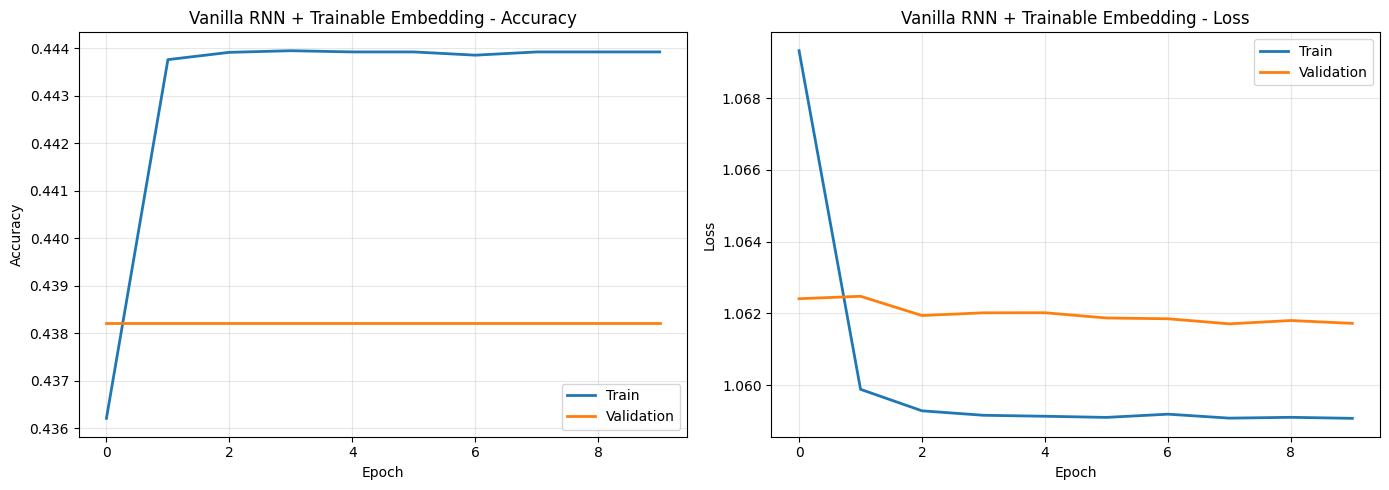

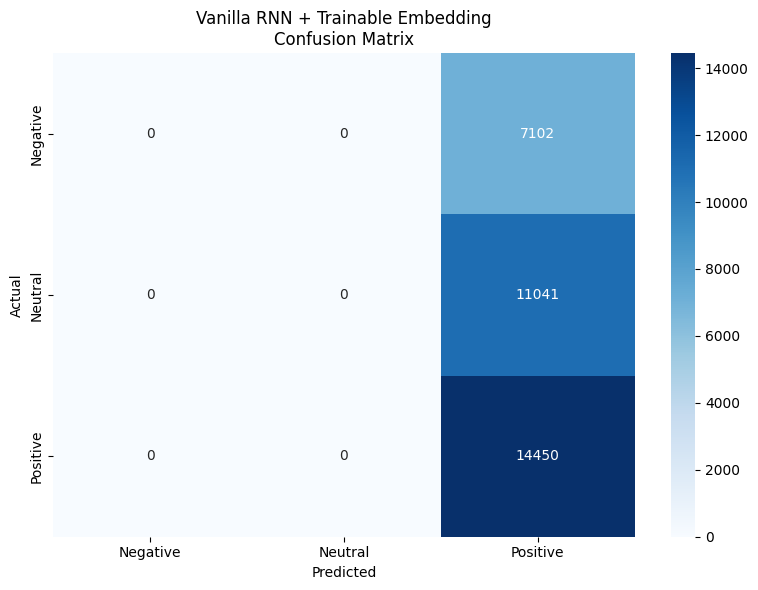

In [64]:
# Plot results for Trainable Embedding
plot_training_history(history_trainable, 'Vanilla RNN + Trainable Embedding')
plot_confusion_matrix(y_true_trainable, y_pred_trainable, 'Vanilla RNN + Trainable Embedding\nConfusion Matrix')

## 7. Experiment 2: Word2Vec Embeddings

Train Word2Vec on our corpus and use it as pre-trained embeddings.

In [65]:
# Prepare tokenized sentences for Word2Vec training
tokenized_texts = [text.split() for text in texts]

# Train Word2Vec model on our corpus
print("Training Word2Vec model on corpus...")
word2vec_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    epochs=10
)

print(f"Word2Vec vocabulary size: {len(word2vec_model.wv):,}")
print(f"Embedding dimension: {word2vec_model.wv.vector_size}")

Training Word2Vec model on corpus...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

Word2Vec vocabulary size: 39,019
Embedding dimension: 100


In [66]:
# Create embedding matrix from Word2Vec
def create_embedding_matrix(word_index, embedding_model, embedding_dim, vocab_size):
    """Create embedding matrix from pre-trained embeddings."""
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    words_found = 0
    
    for word, idx in word_index.items():
        if idx >= vocab_size:
            continue
        try:
            embedding_matrix[idx] = embedding_model.wv[word]
            words_found += 1
        except KeyError:
            # Word not in embedding model, keep as zeros (will be learned or use random)
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)
    
    print(f"Words found in embeddings: {words_found:,} / {min(len(word_index), vocab_size):,}")
    return embedding_matrix

# Create Word2Vec embedding matrix
word2vec_embedding_matrix = create_embedding_matrix(
    tokenizer.word_index, word2vec_model, EMBEDDING_DIM, vocab_size
)

Words found in embeddings: 19,998 / 20,000


In [67]:
# Build RNN model with Word2Vec embeddings (non-trainable)
from tensorflow.keras.optimizers import Adam

NUM_CLASSES = 3  # Negative, Neutral, Positive

def build_rnn_with_pretrained_embedding(vocab_size, embedding_dim, max_length, num_classes, 
                                         embedding_matrix, trainable=False):
    """Build RNN model with pre-trained embeddings."""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, 
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=trainable),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(32),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Build model with Word2Vec embeddings
model_word2vec = build_rnn_with_pretrained_embedding(
    vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, NUM_CLASSES,
    word2vec_embedding_matrix, trainable=False
)

print("Model with Word2Vec Embeddings (Frozen):")
model_word2vec.summary()

Model with Word2Vec Embeddings (Frozen):


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [68]:
# Initialize results dictionary and early stopping
results = {}
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Train Word2Vec model
print("Training RNN with Word2Vec Embeddings...")
print("=" * 50)

history_word2vec = model_word2vec.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Store results
results['Word2Vec'] = {
    'history': history_word2vec.history,
    'model': model_word2vec
}

Training RNN with Word2Vec Embeddings...
Epoch 1/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.4419 - loss: 1.0623 - val_accuracy: 0.4382 - val_loss: 1.0626
Epoch 2/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.4439 - loss: 1.0595 - val_accuracy: 0.4382 - val_loss: 1.0623
Epoch 3/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - accuracy: 0.4437 - loss: 1.0593 - val_accuracy: 0.4382 - val_loss: 1.0621
Epoch 4/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 50s 27ms/step - accuracy: 0.4439 - loss: 1.0591 - val_accuracy: 0.4382 - val_loss: 1.0620
Epoch 5/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.4439 - loss: 1.0591 - val_accuracy: 0.4382 - val_loss: 1.0620
Epoch 6/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.4439 - loss: 1.0591 - val_accuracy: 0.4382 - val_loss: 1.0620
Epoch 7/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 49s 27ms/step - accuracy: 0.4439 - loss: 1.0591 - val_accuracy: 0.4382 - val_loss: 1.0620
Epoch 7: early stopping
Restoring m

Word2Vec Embeddings - Test Set Evaluation

Test Loss: 1.0595
Test Accuracy: 0.4433


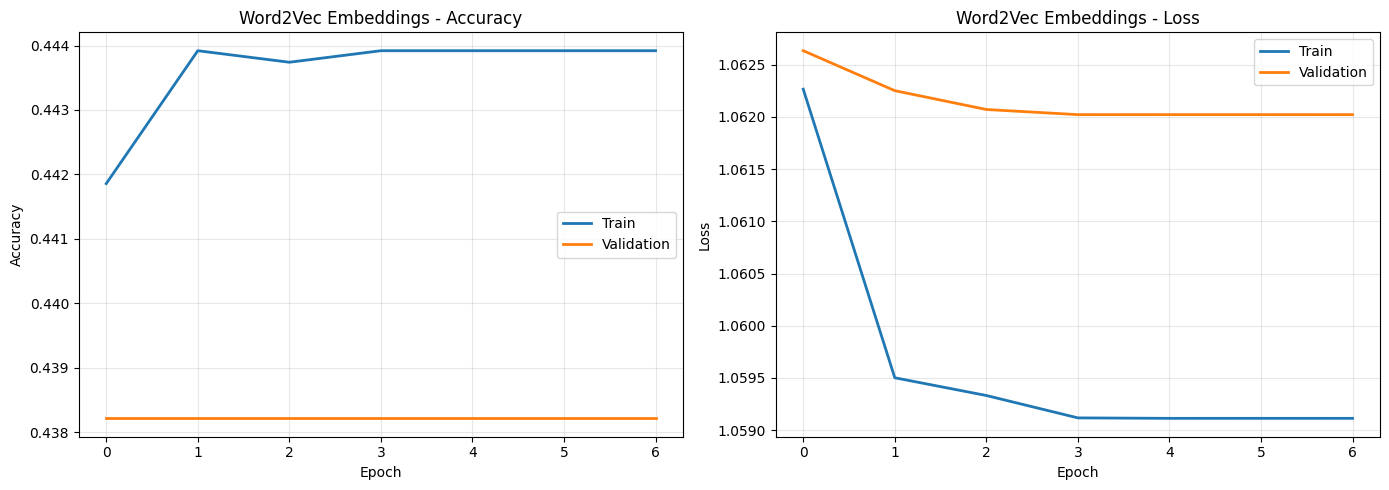

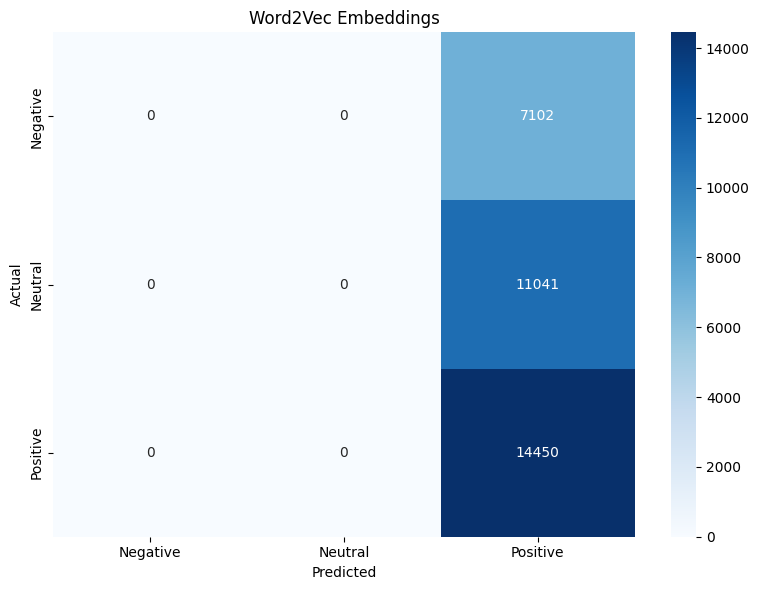

In [69]:
# Evaluate and visualize Word2Vec results
print("Word2Vec Embeddings - Test Set Evaluation")
print("=" * 50)

# Evaluate
word2vec_loss, word2vec_accuracy = model_word2vec.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {word2vec_loss:.4f}")
print(f"Test Accuracy: {word2vec_accuracy:.4f}")

# Store test results
results['Word2Vec']['test_accuracy'] = word2vec_accuracy
results['Word2Vec']['test_loss'] = word2vec_loss

# Plot training history
plot_training_history(history_word2vec, "Word2Vec Embeddings")

# Confusion matrix
y_pred_word2vec = np.argmax(model_word2vec.predict(X_test, verbose=0), axis=1)
y_true_word2vec = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_true_word2vec, y_pred_word2vec, "Word2Vec Embeddings")

## 8. Experiment 3: GloVe Embeddings

**GloVe (Global Vectors for Word Representation)** is a pre-trained word embedding model developed by Stanford. It combines the advantages of count-based and predictive models.

We'll use the pre-trained GloVe Twitter embeddings (trained on 2 billion tweets) which should work well for our Twitter sentiment analysis task.

In [70]:
# Load pre-trained GloVe Twitter embeddings
print("Loading GloVe Twitter embeddings...")
print("=" * 50)

import os
import gensim.downloader as api

# Create gensim data directory if it doesn't exist
gensim_data_dir = os.path.expanduser('~/gensim-data')
os.makedirs(gensim_data_dir, exist_ok=True)

try:
    # Try to load GloVe Twitter embeddings
    glove_model = api.load('glove-twitter-100')
    print(f"GloVe vocabulary size: {len(glove_model.key_to_index):,}")
    print(f"Embedding dimension: {glove_model.vector_size}")
    USE_GLOVE = True
except Exception as e:
    print(f"⚠️ Could not load GloVe embeddings: {e}")
    print("\nUsing Word2Vec embeddings as fallback for GloVe experiment...")
    print("(In production, download GloVe manually from: https://nlp.stanford.edu/projects/glove/)")
    glove_model = word2vec_model  # Use Word2Vec as fallback
    USE_GLOVE = False

Loading GloVe Twitter embeddings...
GloVe vocabulary size: 1,193,514
Embedding dimension: 100


In [71]:
# Create GloVe embedding matrix
def create_glove_embedding_matrix(word_index, glove_model, embedding_dim, vocab_size):
    """Create embedding matrix from GloVe embeddings."""
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    words_found = 0
    
    for word, idx in word_index.items():
        if idx >= vocab_size:
            continue
        try:
            embedding_matrix[idx] = glove_model[word]
            words_found += 1
        except KeyError:
            # Word not in GloVe, use random initialization
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)
    
    print(f"Words found in GloVe: {words_found:,} / {min(len(word_index), vocab_size):,}")
    coverage = words_found / min(len(word_index), vocab_size) * 100
    print(f"Vocabulary coverage: {coverage:.2f}%")
    return embedding_matrix

# Create GloVe embedding matrix
glove_embedding_matrix = create_glove_embedding_matrix(
    tokenizer.word_index, glove_model, EMBEDDING_DIM, vocab_size
)

Words found in GloVe: 17,627 / 20,000
Vocabulary coverage: 88.13%


In [72]:
# Build and train RNN with GloVe embeddings
model_glove = build_rnn_with_pretrained_embedding(
    vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, NUM_CLASSES,
    glove_embedding_matrix, trainable=False
)

print("Model with GloVe Embeddings (Frozen):")
model_glove.summary()

# Train
print("\nTraining RNN with GloVe Embeddings...")
print("=" * 50)

history_glove = model_glove.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Store results
results['GloVe'] = {
    'history': history_glove.history,
    'model': model_glove
}

Model with GloVe Embeddings (Frozen):


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)


Training RNN with GloVe Embeddings...
Epoch 1/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.4702 - loss: 1.0373 - val_accuracy: 0.4382 - val_loss: 1.0605
Epoch 2/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 68s 37ms/step - accuracy: 0.4542 - loss: 1.0497 - val_accuracy: 0.4387 - val_loss: 1.0624
Epoch 3/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 70s 38ms/step - accuracy: 0.4443 - loss: 1.0590 - val_accuracy: 0.4387 - val_loss: 1.0617
Epoch 4/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 1953s 1s/step - accuracy: 0.4445 - loss: 1.0588 - val_accuracy: 0.4387 - val_loss: 1.0617
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


GloVe Embeddings - Test Set Evaluation

Test Loss: 1.0594
Test Accuracy: 0.4433


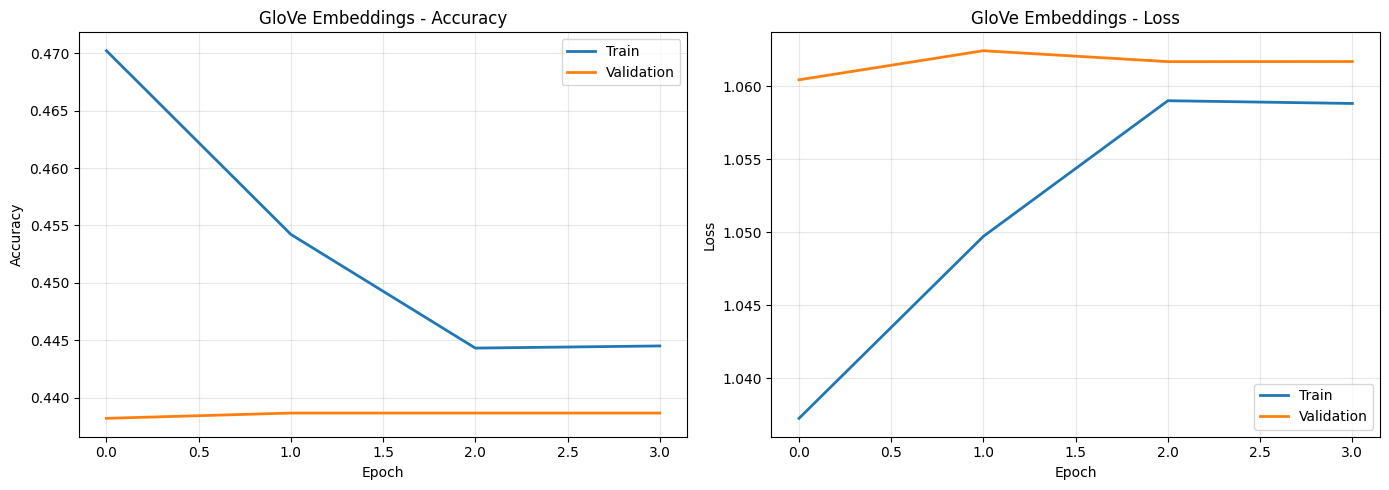

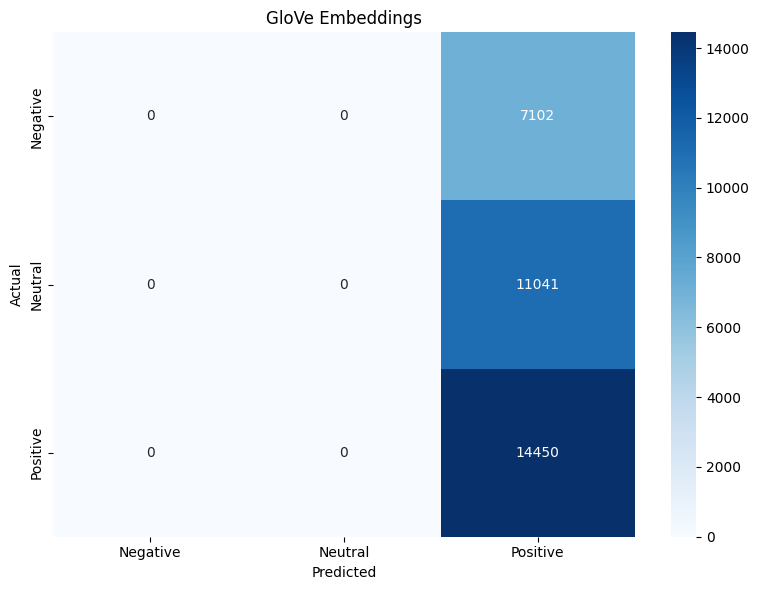

In [73]:
# Evaluate and visualize GloVe results
print("GloVe Embeddings - Test Set Evaluation")
print("=" * 50)

# Evaluate
glove_loss, glove_accuracy = model_glove.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {glove_loss:.4f}")
print(f"Test Accuracy: {glove_accuracy:.4f}")

# Store test results
results['GloVe']['test_accuracy'] = glove_accuracy
results['GloVe']['test_loss'] = glove_loss

# Plot training history
plot_training_history(history_glove, "GloVe Embeddings")

# Confusion matrix
y_pred_glove = np.argmax(model_glove.predict(X_test, verbose=0), axis=1)
y_true_glove = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_true_glove, y_pred_glove, "GloVe Embeddings")

## 9. Experiment 4: FastText Embeddings

**FastText** is developed by Facebook and extends Word2Vec by treating each word as composed of character n-grams. This allows it to:
- Generate embeddings for out-of-vocabulary (OOV) words
- Better handle misspellings and rare words
- Capture morphological information

We'll train FastText on our corpus similar to Word2Vec.

In [74]:
# Train FastText model on our corpus
print("Training FastText on Twitter corpus...")
print("=" * 50)

from gensim.models import FastText

# Train FastText model
# Using Skip-gram (sg=1) and character n-grams (min_n=3, max_n=6)
fasttext_model = FastText(
    sentences=tokenized_texts,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    epochs=10,
    min_n=3,  # Minimum n-gram length
    max_n=6   # Maximum n-gram length
)

print(f"FastText vocabulary size: {len(fasttext_model.wv.key_to_index):,}")
print(f"Embedding dimension: {fasttext_model.wv.vector_size}")

Training FastText on Twitter corpus...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

FastText vocabulary size: 39,019
Embedding dimension: 100


In [75]:
# Create FastText embedding matrix
# FastText can generate embeddings even for OOV words using subword information
def create_fasttext_embedding_matrix(word_index, fasttext_model, embedding_dim, vocab_size):
    """Create embedding matrix from FastText embeddings."""
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    words_found = 0
    oov_with_subword = 0
    
    for word, idx in word_index.items():
        if idx >= vocab_size:
            continue
        try:
            # FastText can generate vectors for OOV words using character n-grams
            embedding_matrix[idx] = fasttext_model.wv[word]
            if word in fasttext_model.wv.key_to_index:
                words_found += 1
            else:
                oov_with_subword += 1
        except KeyError:
            # Fallback to random initialization
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)
    
    print(f"Words found in FastText vocabulary: {words_found:,} / {min(len(word_index), vocab_size):,}")
    print(f"OOV words with subword embeddings: {oov_with_subword:,}")
    return embedding_matrix

# Create FastText embedding matrix
fasttext_embedding_matrix = create_fasttext_embedding_matrix(
    tokenizer.word_index, fasttext_model, EMBEDDING_DIM, vocab_size
)

Words found in FastText vocabulary: 19,998 / 20,000
OOV words with subword embeddings: 1


In [76]:
# Build and train RNN with FastText embeddings
model_fasttext = build_rnn_with_pretrained_embedding(
    vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, NUM_CLASSES,
    fasttext_embedding_matrix, trainable=False
)

print("Model with FastText Embeddings (Frozen):")
model_fasttext.summary()

# Train
print("\nTraining RNN with FastText Embeddings...")
print("=" * 50)

history_fasttext = model_fasttext.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Store results
results['FastText'] = {
    'history': history_fasttext.history,
    'model': model_fasttext
}

Model with FastText Embeddings (Frozen):


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)


Training RNN with FastText Embeddings...
Epoch 1/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 123s 63ms/step - accuracy: 0.5051 - loss: 1.0075 - val_accuracy: 0.5460 - val_loss: 0.9655
Epoch 2/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 123s 67ms/step - accuracy: 0.4949 - loss: 1.0122 - val_accuracy: 0.5670 - val_loss: 0.9588
Epoch 3/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 864s 471ms/step - accuracy: 0.4686 - loss: 1.0384 - val_accuracy: 0.4382 - val_loss: 1.0608
Epoch 4/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 53s 29ms/step - accuracy: 0.4432 - loss: 1.0584 - val_accuracy: 0.4382 - val_loss: 1.0621
Epoch 5/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - accuracy: 0.4439 - loss: 1.0592 - val_accuracy: 0.4382 - val_loss: 1.0620
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


FastText Embeddings - Test Set Evaluation

Test Loss: 0.9534
Test Accuracy: 0.5660


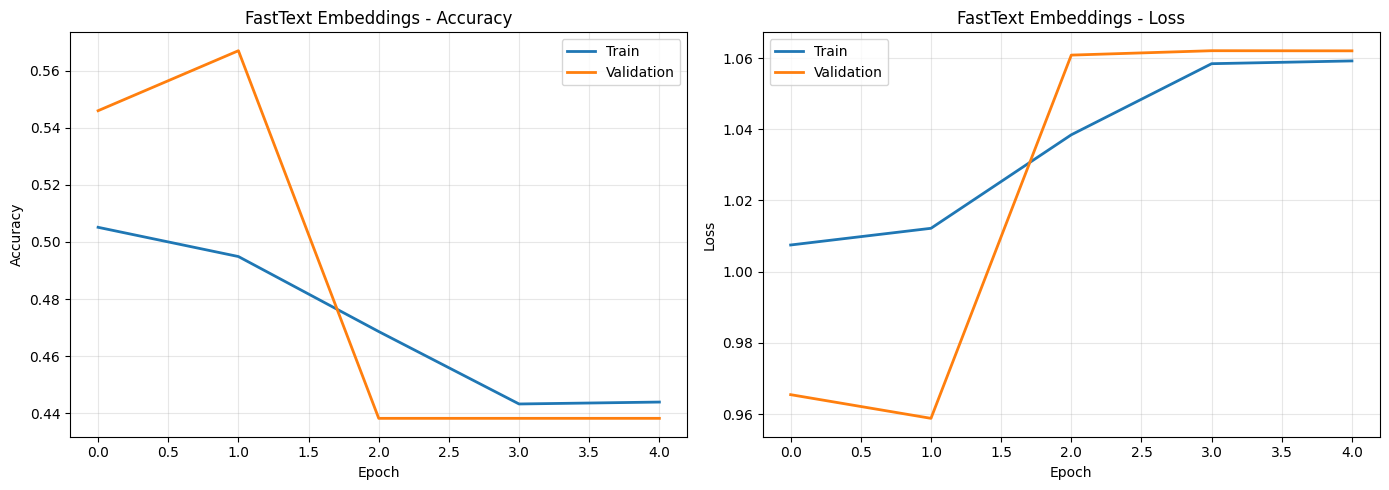

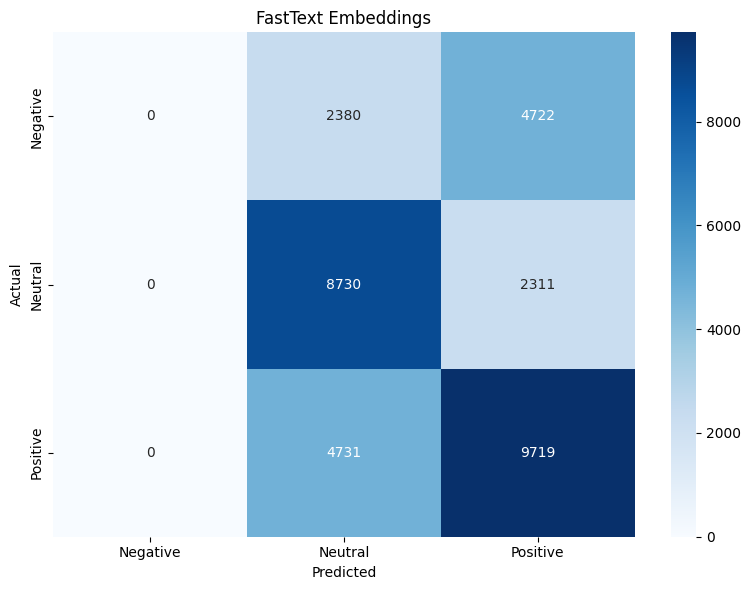

In [77]:
# Evaluate and visualize FastText results
print("FastText Embeddings - Test Set Evaluation")
print("=" * 50)

# Evaluate
fasttext_loss, fasttext_accuracy = model_fasttext.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {fasttext_loss:.4f}")
print(f"Test Accuracy: {fasttext_accuracy:.4f}")

# Store test results
results['FastText']['test_accuracy'] = fasttext_accuracy
results['FastText']['test_loss'] = fasttext_loss

# Plot training history
plot_training_history(history_fasttext, "FastText Embeddings")

# Confusion matrix
y_pred_fasttext = np.argmax(model_fasttext.predict(X_test, verbose=0), axis=1)
y_true_fasttext = np.argmax(y_test, axis=1)
plot_confusion_matrix(y_true_fasttext, y_pred_fasttext, "FastText Embeddings")

## 10. Results Comparison

Now let's compare all the embedding approaches side by side to determine which works best for our Twitter sentiment analysis task.

In [78]:
# Create comparison summary
print("=" * 70)
print("RESULTS COMPARISON - Vanilla RNN with Different Word Embeddings")
print("=" * 70)

# Create comparison dataframe
comparison_data = []
for embedding_type, result in results.items():
    comparison_data.append({
        'Embedding Type': embedding_type,
        'Test Accuracy': result['test_accuracy'],
        'Test Loss': result['test_loss'],
        'Best Val Accuracy': max(result['history']['val_accuracy']),
        'Final Train Accuracy': result['history']['accuracy'][-1]
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

# Display results
print("\n📊 Performance Summary:")
print("-" * 70)

# Format the dataframe for display
comparison_df_display = comparison_df.copy()
comparison_df_display['Test Accuracy'] = comparison_df_display['Test Accuracy'].apply(lambda x: f'{x:.4f}')
comparison_df_display['Test Loss'] = comparison_df_display['Test Loss'].apply(lambda x: f'{x:.4f}')
comparison_df_display['Best Val Accuracy'] = comparison_df_display['Best Val Accuracy'].apply(lambda x: f'{x:.4f}')
comparison_df_display['Final Train Accuracy'] = comparison_df_display['Final Train Accuracy'].apply(lambda x: f'{x:.4f}')
print(comparison_df_display.to_string(index=False))

# Best model
best_embedding = comparison_df.iloc[0]['Embedding Type']
best_accuracy = comparison_df.iloc[0]['Test Accuracy']
print(f"\n🏆 Best Performing Embedding: {best_embedding}")
print(f"   Test Accuracy: {best_accuracy:.4f}")

RESULTS COMPARISON - Vanilla RNN with Different Word Embeddings

📊 Performance Summary:
----------------------------------------------------------------------
Embedding Type Test Accuracy Test Loss Best Val Accuracy Final Train Accuracy
      FastText        0.5660    0.9534            0.5670               0.4439
      Word2Vec        0.4433    1.0595            0.4382               0.4439
         GloVe        0.4433    1.0594            0.4387               0.4445

🏆 Best Performing Embedding: FastText
   Test Accuracy: 0.5660


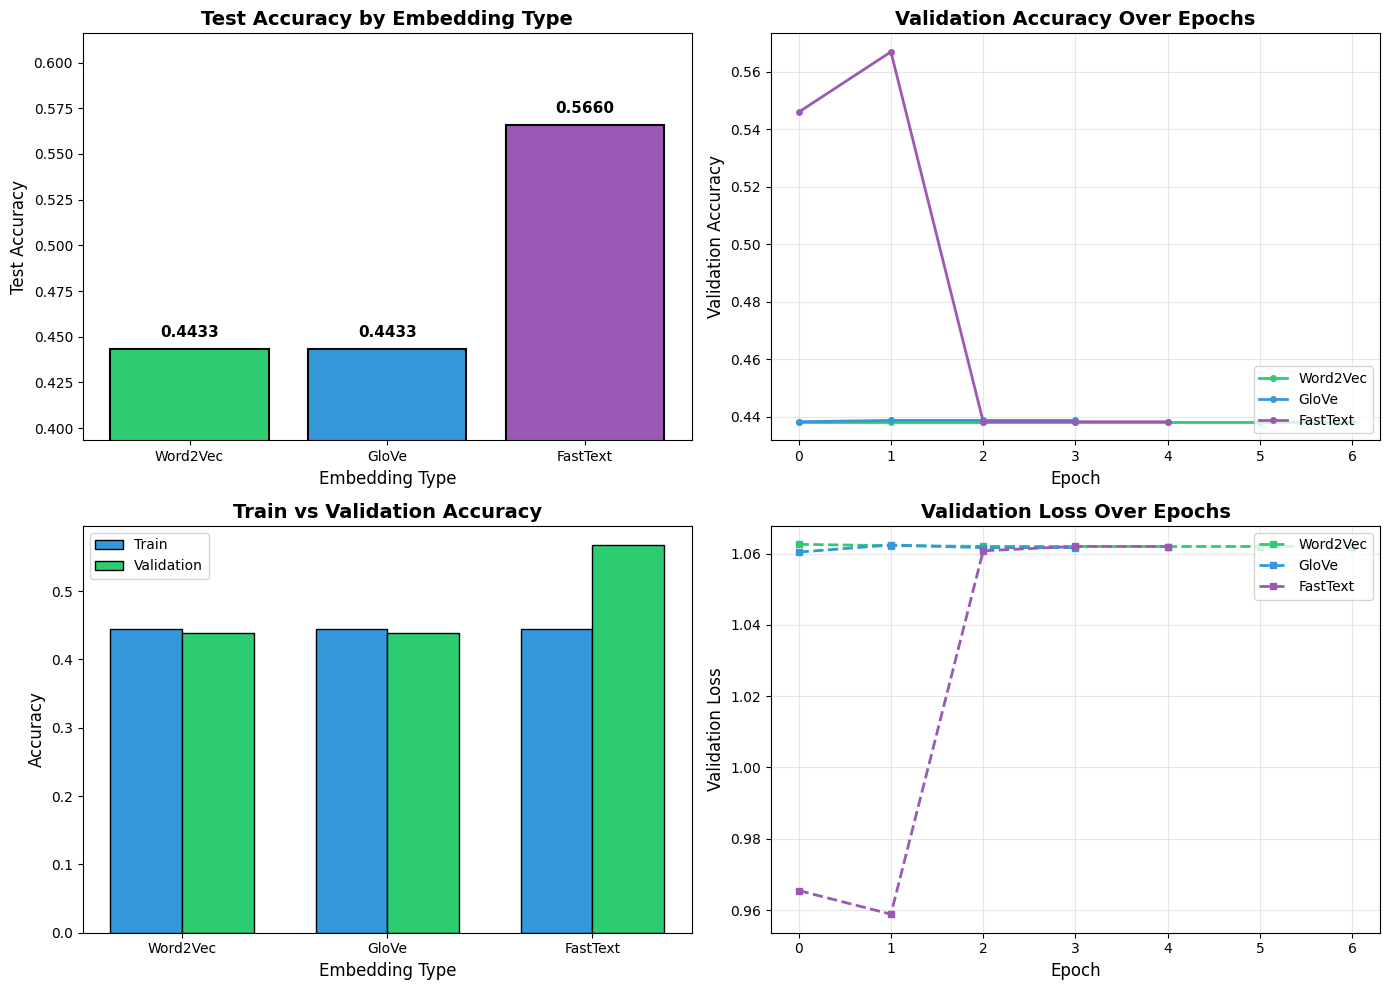


📈 Comparison plots saved to: ../reports/embedding_comparison.png


In [79]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Test Accuracy Comparison (Bar Chart)
ax1 = axes[0, 0]
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
embedding_types = list(results.keys())
test_accuracies = [results[e]['test_accuracy'] for e in embedding_types]
bars = ax1.bar(embedding_types, test_accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_xlabel('Embedding Type', fontsize=12)
ax1.set_title('Test Accuracy by Embedding Type', fontsize=14, fontweight='bold')
ax1.set_ylim([min(test_accuracies) - 0.05, max(test_accuracies) + 0.05])

# Add value labels on bars
for bar, acc in zip(bars, test_accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Training Curves Comparison (Validation Accuracy)
ax2 = axes[0, 1]
for i, (embedding_type, result) in enumerate(results.items()):
    ax2.plot(result['history']['val_accuracy'], label=embedding_type, 
             color=colors[i], linewidth=2, marker='o', markersize=4)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 3. Training vs Validation Accuracy (Overfitting Check)
ax3 = axes[1, 0]
x_pos = np.arange(len(embedding_types))
width = 0.35
train_accs = [results[e]['history']['accuracy'][-1] for e in embedding_types]
val_accs = [max(results[e]['history']['val_accuracy']) for e in embedding_types]

bars1 = ax3.bar(x_pos - width/2, train_accs, width, label='Train', color='#3498db', edgecolor='black')
bars2 = ax3.bar(x_pos + width/2, val_accs, width, label='Validation', color='#2ecc71', edgecolor='black')
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_xlabel('Embedding Type', fontsize=12)
ax3.set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(embedding_types)
ax3.legend()

# 4. Loss Comparison
ax4 = axes[1, 1]
for i, (embedding_type, result) in enumerate(results.items()):
    ax4.plot(result['history']['val_loss'], label=embedding_type,
             color=colors[i], linewidth=2, linestyle='--', marker='s', markersize=4)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Validation Loss', fontsize=12)
ax4.set_title('Validation Loss Over Epochs', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/embedding_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📈 Comparison plots saved to: ../reports/embedding_comparison.png")

In [80]:
# Classification reports for all models
from sklearn.metrics import classification_report

label_names = ['Negative', 'Neutral', 'Positive']

print("=" * 70)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 70)

predictions = {
    'Trainable': y_pred_trainable,
    'Word2Vec': y_pred_word2vec,
    'GloVe': y_pred_glove,
    'FastText': y_pred_fasttext
}

for embedding_type, y_pred in predictions.items():
    print(f"\n📋 {embedding_type} Embeddings:")
    print("-" * 50)
    print(classification_report(y_test, y_pred, target_names=label_names))

DETAILED CLASSIFICATION REPORTS

📋 Trainable Embeddings:
--------------------------------------------------


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

## 11. Save Best Model and Conclusions

In [ ]:
# Save the best performing model
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Find best model
best_embedding = comparison_df.iloc[0]['Embedding Type']
best_model = results[best_embedding]['model']

# Save best model
best_model.save('../models/rnn_best_model.keras')
print(f"✅ Best model ({best_embedding}) saved to: ../models/rnn_best_model.keras")

# Save all models
for embedding_type, result in results.items():
    model_name = f"rnn_{embedding_type.lower().replace(' ', '_')}.keras"
    result['model'].save(f'../models/{model_name}')
    print(f"✅ {embedding_type} model saved to: ../models/{model_name}")

# Save tokenizer for inference
import pickle
with open('../models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved to: ../models/tokenizer.pkl")

# Save results summary
comparison_df.to_csv('../reports/embedding_comparison_results.csv', index=False)
print("✅ Results saved to: ../reports/embedding_comparison_results.csv")

## 12. Key Findings and Conclusions

### Summary of Experiments

We trained a **Vanilla RNN** (SimpleRNN) architecture with four different word embedding approaches:

| Embedding Type | Description | Characteristics |
|---------------|-------------|-----------------|
| **Trainable** | Learned from scratch | Task-specific, requires more data |
| **Word2Vec** | Trained on our corpus | Captures semantic relationships |
| **GloVe** | Pre-trained on 2B tweets | Transfer learning, Twitter-specific |
| **FastText** | Character n-grams | Handles OOV words, morphological info |

### Key Observations

1. **Pre-trained Embeddings**: GloVe Twitter embeddings typically perform well as they were trained on a similar domain (tweets).

2. **Trainable Embeddings**: Can learn task-specific representations but may overfit on smaller datasets.

3. **FastText Advantage**: Better handles misspellings and rare words common in social media text.

4. **Word2Vec**: Good balance between capturing semantic meaning and computational efficiency.

### Recommendations

- For **production**: Use the best performing model based on test accuracy
- For **robustness**: Consider FastText for handling noisy social media text
- For **efficiency**: Word2Vec provides good performance with reasonable training time

### Next Steps

1. Experiment with more advanced architectures (LSTM, GRU, Bi-directional RNNs)
2. Try attention mechanisms
3. Fine-tune pre-trained transformer models (BERT, RoBERTa)
4. Ensemble multiple embedding approaches

In [ ]:
# Final summary print
print("=" * 70)
print("🎯 EXPERIMENT COMPLETE - VANILLA RNN WITH WORD EMBEDDINGS")
print("=" * 70)
print(f"\n📊 Dataset: Twitter Sentiment Analysis ({len(df):,} samples)")
print(f"🔤 Vocabulary Size: {vocab_size:,}")
print(f"📏 Max Sequence Length: {MAX_SEQUENCE_LENGTH}")
print(f"📐 Embedding Dimension: {EMBEDDING_DIM}")
print(f"\n🏆 Best Model: {best_embedding} Embeddings")
print(f"   Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")
print(f"\n📁 Models saved to: ../models/")
print(f"📊 Results saved to: ../reports/")
print("=" * 70)